**Goal**: Compute descriptive info on the dataset of quantum programs.

# Dataset Statistics (Qiskit and Cirq)

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

In [146]:
DIR_DATASET_QISKIT = '../data/datasets/exp_v06'
DIR_DATASET_CIRQ = '../data/datasets/exp_v07'
PAPER_DIR = '../data/paper_images'

In [4]:
import os

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions

def create_pandas(file_extensions: dict) -> pd.DataFrame:
    """Create a pandas dataframe from a dictionary {filename: its extension, etc.}."""
    df = pd.DataFrame.from_dict(file_extensions, orient='index', columns=['extension'])
    df['filename'] = df.index
    # drop index
    df.reset_index(drop=True, inplace=True)
    df['filename'] = df['filename'].astype(str)
    df['extension'] = df['extension'].astype(str)
    return df


In [5]:
def get_stats_on(dataset_folder: str, platform_name: str):
    """Print the summary stats of the given folder."""

    ext_dict_selected = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'files_selected'))
    df_selected = create_pandas(ext_dict_selected)

    ext_dict_all = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'raw_files'))
    df_all = create_pandas(ext_dict_all)

    df_merged = pd.merge(
        df_selected, df_all, 
        on='filename', how='left',
        suffixes=('_selected', '_all'))

    # countplot with percentage of py and ipynb files
    total_unique_files = df_merged.shape[0]
    total_raw_files = df_all.shape[0]
    perc_py = (df_merged[df_merged['extension_all'] == '.py'].shape[0] / total_unique_files) * 100
    perc_ipynb = (df_merged[df_merged['extension_all'] == '.ipynb'].shape[0] / total_unique_files) * 100
    print(f'Percentage of .py files: {perc_py:.1f} %')
    print(f'Percentage of .ipynb files: {perc_ipynb:.1f} %')
    print(f'Total unique files: {total_unique_files}')
    print(f'Total files (scraped): {total_raw_files}')

    print("\\newcommand{\\nProgramsScraped" + platform_name + "}{" + f"{total_raw_files:,}" + "}")
    print("\\newcommand{\\nProgramsSelected" + platform_name + "}{" + f"{total_unique_files:,}" + "}")
    print("\\newcommand{\\nProgramsPy" + platform_name + "}{" + f"{perc_py:.1f}" + "\%}")
    print("\\newcommand{\\nProgramsIpynb" + platform_name + "}{" + f"{perc_ipynb:.1f}" + "\%}")
    
    fig, ax = plt.subplots(figsize=(5, 1))
    sns.countplot(
        data=df_merged, 
        y='extension_all',
        order=['.py', '.ipynb'],
        ax=ax,
    )
    plt.title('Number of files per extension')


Percentage of .py files: 85.8 %
Percentage of .ipynb files: 14.2 %
Total unique files: 7614
Total files (scraped): 81862
\newcommand{\nProgramsScrapedQiskit}{81,862}
\newcommand{\nProgramsSelectedQiskit}{7,614}
\newcommand{\nProgramsPyQiskit}{85.8\%}
\newcommand{\nProgramsIpynbQiskit}{14.2\%}


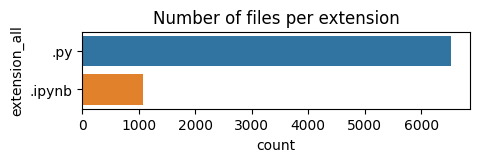

In [6]:
get_stats_on(
    dataset_folder=DIR_DATASET_QISKIT,
    platform_name='Qiskit')

Percentage of .py files: 89.3 %
Percentage of .ipynb files: 10.7 %
Total unique files: 2000
Total files (scraped): 20211
\newcommand{\nProgramsScrapedCirq}{20,211}
\newcommand{\nProgramsSelectedCirq}{2,000}
\newcommand{\nProgramsPyCirq}{89.3\%}
\newcommand{\nProgramsIpynbCirq}{10.7\%}


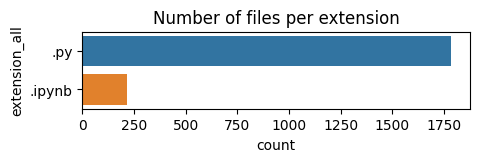

In [7]:
get_stats_on(
    dataset_folder=DIR_DATASET_CIRQ,
    platform_name='Cirq')

## Detectors Info

### Which abstractions are used in the different queries?

In [21]:
import glob
from typing import Dict, List
import re

DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions



query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 9
Number of abstractions: 3
['/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Resource/OversizedCircuit.ql', '/Resource/UnmeasurableQubits.ql', '/Interconnection/IncompatibleComposition.ql', '/Interconnection/UngovernedComposition.ql', '/Interconnection/GhostComposition.ql', '/Optimization/OpAfterOptimization.ql']
['/Register.qll', '/Circuit.qll', '/Gate.qll']


In [22]:
import re

def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.
    
    It uses regex."""
    # all_abstractions = re.findall(r'class (\w+)', content)
    public_abstractions = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return public_abstractions

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 8
['ClassicalRegister', 'QuantumRegister', 'QuantumCircuit', 'TranspiledCircuit', 'Gate', 'MeasureGate', 'MeasurementAll', 'MeasurementAny']


In [78]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.
    
    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used


query_to_abstraction = {}

for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined, 
        content=query_content)
    if abstractions_used:
        base_name = query_name.split('/')[-1].replace('.ql', '')
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')


/Measurement/OpAfterMeasurement.ql: ['Gate', 'MeasureGate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['Gate', 'MeasureGate']
/Resource/OversizedCircuit.ql: ['QuantumCircuit', 'Gate']
/Resource/UnmeasurableQubits.ql: ['QuantumCircuit']
/Interconnection/IncompatibleComposition.ql: ['QuantumCircuit']
/Interconnection/UngovernedComposition.ql: ['QuantumCircuit']
/Interconnection/GhostComposition.ql: ['QuantumCircuit']
/Optimization/OpAfterOptimization.ql: ['TranspiledCircuit', 'Gate']


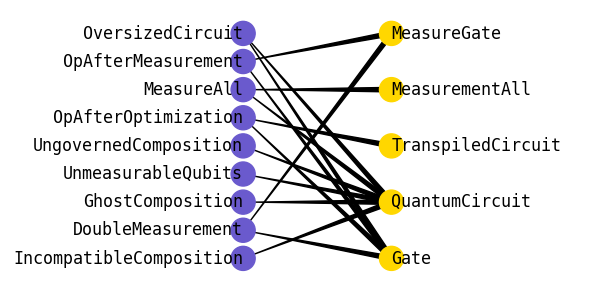

In [235]:
# create bipartite graph of abstractions and queries
import networkx as nx
import matplotlib.pyplot as plt


FONT_SIZE = 12
FONT_FAMILY = 'monospace'
fig, ax = plt.subplots(figsize=(6, 3))
# zoom out to make all the nodes visible
plt.xlim(-3, 3)
G = nx.DiGraph()

# use monospace font

# codeql color background: E8FAFC

# add all queries: color them #E8FAFC
for query_name in query_to_abstraction.keys():
    G.add_node(query_name, bipartite=1)


# add all abstractions: color them orange
for abstractions in query_to_abstraction.values():
    for abstraction in abstractions:
        G.add_node(abstraction, bipartite=0)

# add edges: directed from query to abstraction
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        G.add_edge(abstraction, query_name)
        
# place all abstractions on the left
pos = nx.bipartite_layout(G, nodes=[
    n 
    for n, d in G.nodes(data=True) 
    if d['bipartite'] == 1]
)


color_map = []
left_nodes = []
right_nodes = []
pos_left = {}
pos_right = {}
for node in G:
    if node in query_to_abstraction.keys():
        color_map.append('slateblue')
        left_nodes.append(node)
        pos_left[node] = pos[node]
    else:
        color_map.append('gold')
        right_nodes.append(node)
        pos_right[node] = pos[node]

G_left_nodes = G.subgraph(left_nodes)
G_right_nodes = G.subgraph(right_nodes)


nx.draw(
    G, pos=pos,
    node_color=color_map,
    arrowstyle='wedge',
    ax=ax
)
nx.draw_networkx_labels(
    G_left_nodes, pos=pos_left,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='right'
)


nx.draw_networkx_labels(
    G_right_nodes, pos=pos_right,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='left'
)


# for node in G:
#     print(node, pos[node])

# # get all the references to the text of the labels
# labels = {t.get_text(): t for t in ax.get_children() if isinstance(t, plt.Text)}

# # plot a letter and get the size of it when rendered
# t = plt.text(0, 0, 'A', fontsize=FONT_SIZE, family='monospace')
# char_width = t.get_window_extent().width / plt.gcf().dpi
# print("char_width: ", char_width)
# # remove the letter
# t.remove()




# # print their content and location
# for label, text in labels.items():
#     location = text.get_position()
#     print(label, location)
#     # remove it 
#     if label.strip() != '':
#         text.remove()
#     x, y = location
#     length = len(label)
#     base_distance = 1.5
#     if not label in query_to_abstraction.keys():
#         x_shift = base_distance * char_width 
#     else:
#         x_shift = - ((length) * char_width) 
#     new_x = x + x_shift
#     new_y = y
#     t = plt.text(
#         new_x,
#         new_y,
#         label,
#         fontsize=FONT_SIZE,
#         family='monospace',

#     )
#     t.set_clip_on(False)
plt.tight_layout(
    pad=1,
)
fig.savefig(
    os.path.join(PAPER_DIR, 'abstraction_graph.pdf'))
